<a href="https://colab.research.google.com/github/pritiyadav888/canara/blob/main/Fraud_Detection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and Data Preparation
This section covers the initial setup, including importing necessary libraries, uploading the Kaggle API key, downloading the dataset, and preparing the data for analysis.




Import Libraries and Setup Kaggle


In [5]:
# Import libraries for file upload and installing packages
from google.colab import files
!pip install -q kaggle

# Upload Kaggle API key
files.upload()  # select the kaggle.json file that you downloaded

# Setup Kaggle directory and permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip


Saving kaggle.json to kaggle.json
 92% 61.0M/66.0M [00:00<00:00, 224MB/s]
100% 66.0M/66.0M [00:00<00:00, 204MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [6]:
#Import Libraries for Data Processing and Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [7]:
# Load and Prepare Dataset
# Load the dataset
data = pd.read_csv('creditcard.csv')

# Rename V1-V28 for better understanding
for i in range(1, 29):
    data.rename(columns={f'V{i}': f'Component_{i}'}, inplace=True)

# Scale the 'Time' and 'Amount' features
scaler = StandardScaler()
data['Normalized Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Normalized Time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' features
data.drop(['Time', 'Amount'], axis=1, inplace=True)

# Split the data into features and targets
X = data.drop('Class', axis=1)
y = data['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(data.head())


   Component_1  Component_2  Component_3  Component_4  Component_5  \
0    -1.359807    -0.072781     2.536347     1.378155    -0.338321   
1     1.191857     0.266151     0.166480     0.448154     0.060018   
2    -1.358354    -1.340163     1.773209     0.379780    -0.503198   
3    -0.966272    -0.185226     1.792993    -0.863291    -0.010309   
4    -1.158233     0.877737     1.548718     0.403034    -0.407193   

   Component_6  Component_7  Component_8  Component_9  Component_10  ...  \
0     0.462388     0.239599     0.098698     0.363787      0.090794  ...   
1    -0.082361    -0.078803     0.085102    -0.255425     -0.166974  ...   
2     1.800499     0.791461     0.247676    -1.514654      0.207643  ...   
3     1.247203     0.237609     0.377436    -1.387024     -0.054952  ...   
4     0.095921     0.592941    -0.270533     0.817739      0.753074  ...   

   Component_22  Component_23  Component_24  Component_25  Component_26  \
0      0.277838     -0.110474      0.066928    

Model Training and Evaluation

In [8]:
# Define and Train Models
models = {
    "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(),
    "Quadratic Regression": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "AdaBoost": AdaBoostClassifier()
}

# Create a directory to save models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

best_model = None
best_f1_score = 0
best_model_name = ""

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Handle continuous predictions for Linear and Quadratic Regression
    if name in ["Linear Regression", "Quadratic Regression"]:
        y_pred = np.where(y_pred > 0.5, 1, 0)

    # Calculate F1 Score
    current_f1_score = f1_score(y_test, y_pred, average='binary')

    # Compare with the best F1 Score
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_model = model
        best_model_name = name

    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    # Save the model
    joblib.dump(model, f'models/{name}_model.pkl')

# Save the best model
if best_model:
    joblib.dump(best_model, f'models/best_model_{best_model_name}.pkl')
    print(f"Best model is '{best_model_name}' with an F1 Score of {best_f1_score}.")

Results for Linear Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.46      0.58        98

    accuracy                           1.00     56962
   macro avg       0.89      0.73      0.79     56962
weighted avg       1.00      1.00      1.00     56962

[[56851    13]
 [   53    45]]
Results for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962

[[56851    13]
 [   34    64]]
Results for Quadratic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.78      0.81        98

    accuracy          

Advanced Modeling with Neural Networks

Epoch 1/10
889/889 [==============================] - 10s 4ms/step - loss: 0.4486 - accuracy: 0.9006 - val_loss: 0.0952 - val_accuracy: 0.9804
Epoch 2/10
889/889 [==============================] - 4s 4ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0302 - val_accuracy: 0.9952
Epoch 3/10
889/889 [==============================] - 5s 5ms/step - loss: 0.0458 - accuracy: 0.9891 - val_loss: 0.0379 - val_accuracy: 0.9931
Epoch 4/10
889/889 [==============================] - 4s 4ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.0262 - val_accuracy: 0.9961
Epoch 5/10
889/889 [==============================] - 4s 4ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0186 - val_accuracy: 0.9977
Epoch 6/10
889/889 [==============================] - 4s 5ms/step - loss: 0.0371 - accuracy: 0.9977 - val_loss: 5.1115 - val_accuracy: 0.7267
Epoch 7/10
889/889 [==============================] - 4s 5ms/step - loss: 0.0610 - accuracy: 0.9867 - val_loss: 0.2800 - val_accuracy: 0.9667
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3554/3554 [==============================] - 9s 2ms/step - loss: 1.1965 - accuracy: 0.9468
Synthetic data test accuracy: 0.9468116760253906
[[56738   126]
 [   12    86]]


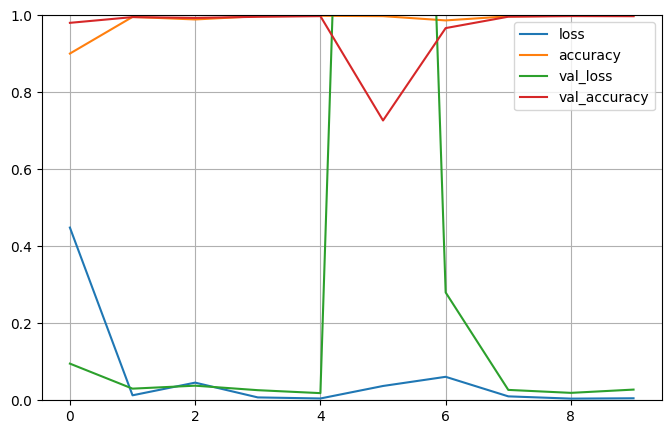

In [9]:
# Install TensorFlow (Google Colab should have TensorFlow preinstalled)
# !pip install tensorflow

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Load the dataset
data = pd.read_csv('creditcard.csv')

# Rename V1-V28 for better understanding
for i in range(1, 29):
    data.rename(columns={f'V{i}': f'Component_{i}'}, inplace=True)

# Scale the 'Time' and 'Amount' features
scaler = StandardScaler()
data['Normalized Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Normalized Time'] = scaler.fit_transform(data['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' features
data.drop(['Time', 'Amount'], axis=1, inplace=True)

# Split the data into features (X) and targets (y) with stratified sampling
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define SMOTE for resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Build the neural network model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_resampled.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Calculate class weights for imbalanced dataset
class_weights = {
    0: (1 / y_train.value_counts()[0]) * (len(y_train) / 2.0),
    1: (1 / y_train.value_counts()[1]) * (len(y_train) / 2.0)
}

# Train the model with GPU acceleration
history = model.fit(X_resampled, y_resampled,
                    epochs=10,
                    batch_size=512,
                    class_weight=class_weights,
                    validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

# Generate classification report
y_pred = model.predict(X_test) > 0.5  # Convert probabilities to binary output
print(classification_report(y_test, y_pred))

model.save('best_fraud_detection_model.h5')

# Optional: Generate synthetic data to test model performance
smote_test = SMOTE(random_state=42)
X_synthetic, y_synthetic = smote_test.fit_resample(X_test, y_test)
synthetic_loss, synthetic_acc = model.evaluate(X_synthetic, y_synthetic)
print('Synthetic data test accuracy:', synthetic_acc)

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot training history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

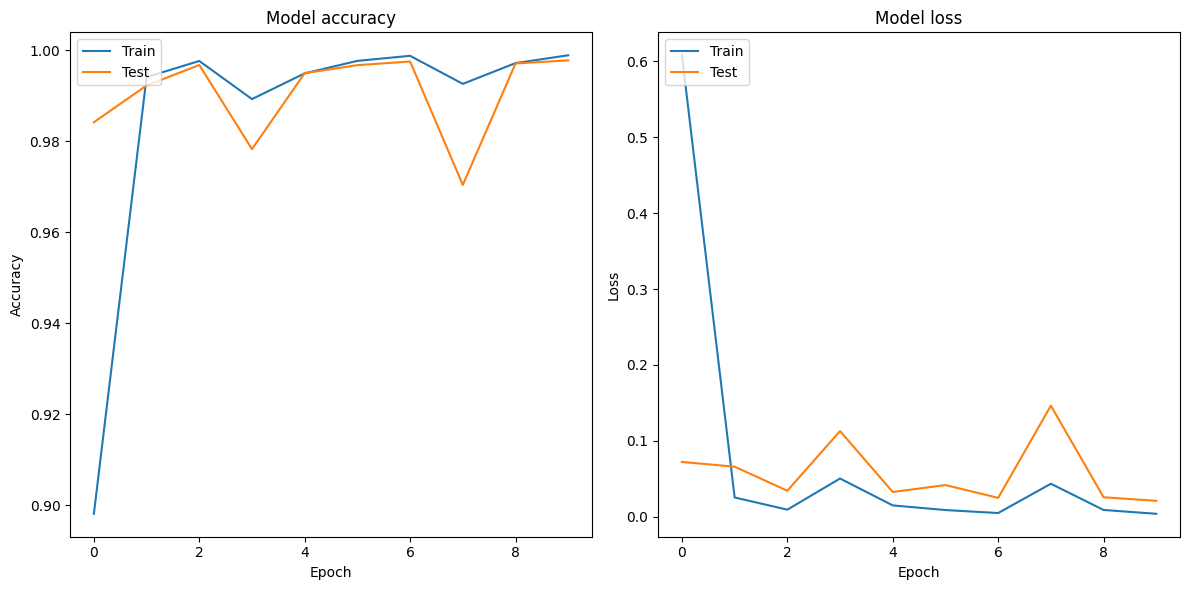

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

Kaggle's approach -https://www.kaggle.com/code/zsinghrahulk/credit-fraud-rf-xgb-lgbm-99-accuracy

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [10]:
# Define the target variable and predictors
data = pd.read_csv('creditcard.csv')
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
              'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
              'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
              'Amount']

# Split the dataset into training and test sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Further split the training set into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42, shuffle=True)


In [12]:
print(train_df.columns)


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [13]:
clf = RandomForestClassifier(n_jobs=5,
                             random_state=42,
                             criterion='gini',
                             n_estimators=100,
                             verbose=False)
clf.fit(train_df[predictors], train_df[target].values)
preds = clf.predict(valid_df[predictors])

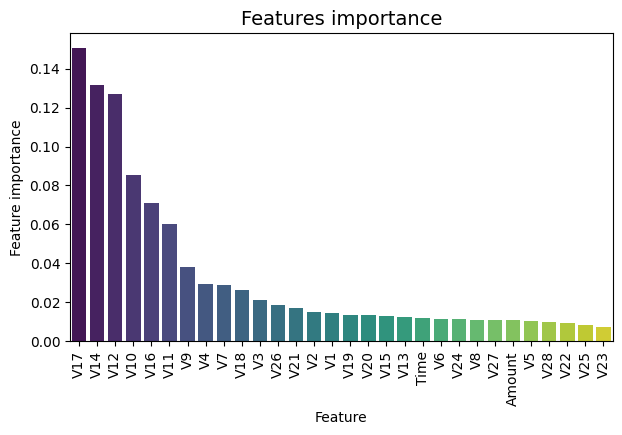

In [14]:
### Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp,palette = 'viridis')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

<Figure size 1000x500 with 0 Axes>

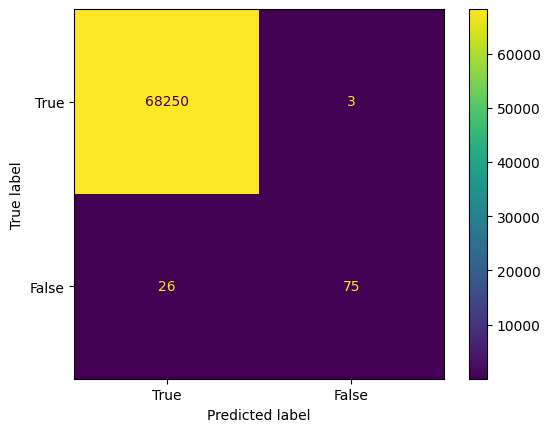

In [15]:
conf_mat = confusion_matrix(valid_df[target], preds )
disp = metrics.ConfusionMatrixDisplay(conf_mat,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(valid_df[target] , preds)
precision = precision_score(valid_df[target] , preds)
recall = recall_score(valid_df[target] , preds)
f1 = f1_score(valid_df[target] , preds)

new_row = {'model':'RF','accuracy':accuracy , 'precision':precision,'recall':recall ,'f1': f1 }
print(new_row)

{'model': 'RF', 'accuracy': 0.9995757380694619, 'precision': 0.9615384615384616, 'recall': 0.7425742574257426, 'f1': 0.8379888268156426}


<Figure size 1000x500 with 0 Axes>

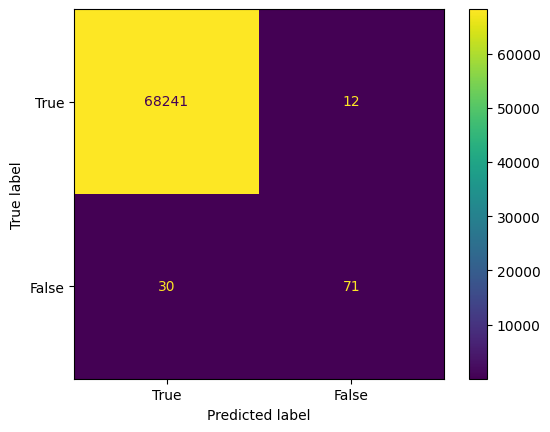

In [17]:
# Create an XGBoost model
xgb_model = xgb.XGBClassifier( objective ='binary:logistic', max_depth = 3,  learning_rate = 0.01,   n_estimators = 100 )

# Train the model
xgb_model.fit(train_df[predictors], train_df[target].values)

# Make predictions on the test set
y_pred = xgb_model.predict(valid_df[predictors])

conf_mat = confusion_matrix( valid_df[target] , y_pred )
disp = metrics.ConfusionMatrixDisplay(conf_mat,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()
plt.show()

In [18]:
accuracy = accuracy_score(valid_df[target] , y_pred)
precision = precision_score(valid_df[target] , y_pred)
recall = recall_score(valid_df[target] , y_pred)
f1 = f1_score(valid_df[target] , y_pred)

new_row = {'model':'XGB','accuracy':accuracy , 'precision':precision,'recall':recall ,'f1': f1 }
print(new_row)

{'model': 'XGB', 'accuracy': 0.9993855516868069, 'precision': 0.8554216867469879, 'recall': 0.7029702970297029, 'f1': 0.7717391304347826}


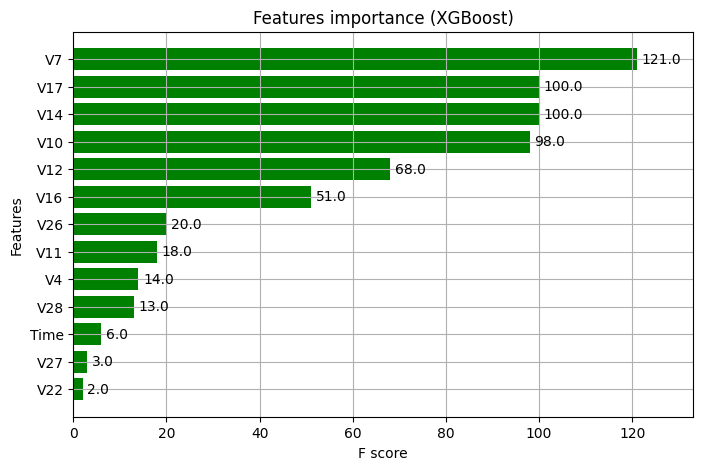

In [19]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(xgb_model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green")
plt.show()

<Figure size 1000x500 with 0 Axes>

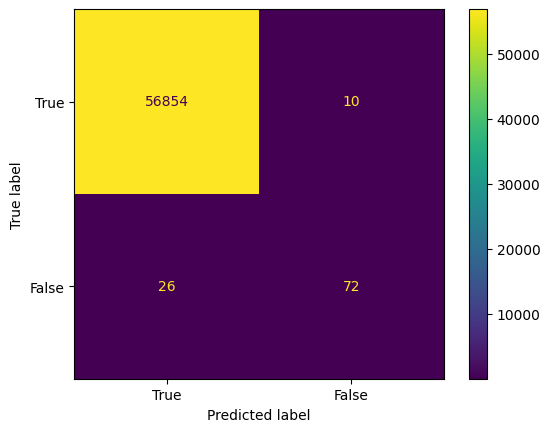

{'model': 'XGB', 'accuracy': 0.9993679997191109, 'precision': 0.8780487804878049, 'recall': 0.7346938775510204, 'f1': 0.8}


In [20]:
# Make predictions on the test set
y_pred = xgb_model.predict(test_df[predictors])

conf_mat = confusion_matrix( test_df[target] , y_pred )
disp = metrics.ConfusionMatrixDisplay(conf_mat,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()
plt.show()

accuracy = accuracy_score(test_df[target] , y_pred)
precision = precision_score(test_df[target] , y_pred)
recall = recall_score(test_df[target] , y_pred)
f1 = f1_score(test_df[target] , y_pred)

new_row = {'model':'XGB','accuracy':accuracy , 'precision':precision,'recall':recall ,'f1': f1 }
print(new_row)

Techniques such as cross-validation, regularization, and early stopping to prevent overfitting.

In [22]:
!pip install lightgbm --upgrade


In [31]:
!pip install tabgan==1.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.2 MB/s eta 0:00:00


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.953483


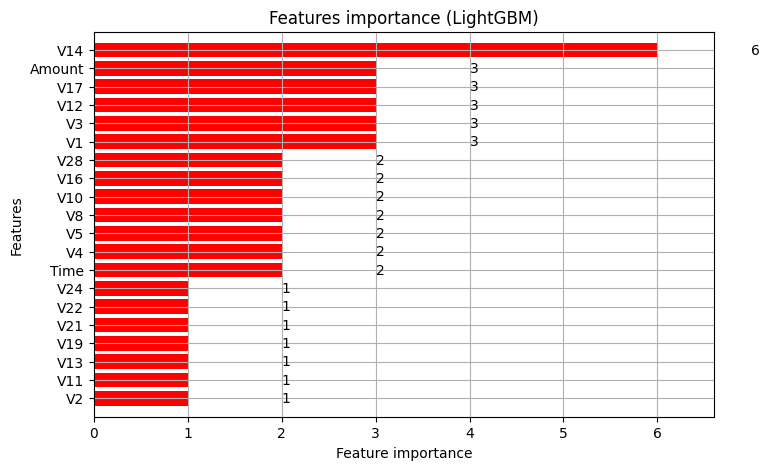

ROC AUC Score: 0.9620348192034271


In [37]:
# LightGBM
import lightgbm as lgb
VERBOSE_EVAL = 100
# Create LightGBM datasets
dtrain = lgb.Dataset(train_df[predictors], label=train_df[target])
dvalid = lgb.Dataset(valid_df[predictors], label=valid_df[target])

# Create LightGBM datasets
dtrain = lgb.Dataset(train_df[predictors], label=train_df[target])
dvalid = lgb.Dataset(valid_df[predictors], label=valid_df[target])

# Specify the model configuration
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 7,
    'max_depth': 4,
    'min_child_samples': 100,
    'max_bin': 100,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 150,
}

# Train the model with early stopping using callbacks
model = lgb.train(params,
                  dtrain,
                  valid_sets=[dvalid],
                  num_boost_round=1000,
                  callbacks=[lgb.early_stopping(stopping_rounds=100)])

# Plot feature importance
fig, ax = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax, color="red")
plt.show()

# Make predictions and evaluate
preds = model.predict(test_df[predictors])
roc_score = roc_auc_score(test_df[target].values, preds)
print("ROC AUC Score:", roc_score)